In [1]:
import sys  
sys.path.append(r'../source')  
import utils
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import topics_holder as th
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics    
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import spacy
from utils import ReviewsDataset, LSTM_fixed_len

# Origen de los datos

El fichero que contiene las opiniones que vamos a procesar y analizar se encuentra en esta [página web](https://nijianmo.github.io/amazon/index.html#files). Concretamente, [este](http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz) es el enlace al fichero.

Este portal pertenece a la Universidad de California San Diego y es mantenido por Jianmo Ni Ph.D. Contiene multitud de datasets de opiniones de Amazon, clasificados por departamento (Books, Electronics, Software...). El fichero que se procesa en este trabajo es el correspondiente al departamento de Electronics. Se trata de un json de nombre Electronics_5. El número 5 indica que solo aparecen opiniones de productos que tengan, al menos, 5 opiniones.

# Análisis exploratorio sin entrar en el contenido

En esta sección vamos a visualizar las primeras líneas del fichero Electronics_5.json tal y como están en el fichero. A continuación generaremos y analizaremos el objeto data_raw_0, que es un DataFrame de Pandas en el cual se han realizado algunas transformaciones mínimas.

Veamos en primer lugar el contenido del fichero:

In [2]:
utils.get_first_lines_electronics_5(10)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400
5,4.0,NaN,True,"06 5, 2013",A3IYSOTP3HA77N,0380709473,{'Format:': ' Kindle Edition'},B. Marks,I read this probably 50 years ago in my youth ...,Above average mystery,1370390400
6,5.0,NaN,True,"06 27, 2016",A11SXV34PZUQ5E,0380709473,{'Format:': ' Kindle Edition'},Tom C.,I read every Perry mason book voraciously. Fin...,Lam is cool!,1466985600
7,5.0,NaN,True,"07 30, 2015",A2AUQM1HT2D5T8,0380709473,{'Format:': ' Kindle Edition'},ema,I love this series of Bertha and Lamb.. Great...,Five Stars,1438214400
8,5.0,NaN,True,"02 16, 2015",A3UD8JRWLX6SRX,0380709473,{'Format:': ' Paperback'},Michael O.,Great read!,Five Stars,1424044800
9,4.0,NaN,False,"11 21, 2013",A3MV1KKHX51FYT,0380709473,{'Format:': ' Paperback'},Acute Observer,"Crows Can't Count, A.A. Fair\n\nMr. Harry Shar...",A Fast and Far Moving Adventure,1384992000


Veamos los campos que componen el fichero y su significado, acorde a lo explicado en el portal original:
* __overall:__ corresponde a la puntuación que el usuario ha otorgado al producto. Sus valores pueden ser 1, 2, 3, 4 o 5.
* __vote:__ es la cantidad de votos que la opinión ha recibido. Estos votos indican que la opinión ha sido útil para otros usuarios.
* __verified:__ booleano que indica si la compra está o no verificada por Amazon. Esta verificación permite a Amazon garantizar que el usuario que publica la opinión ha comprado, efectivamente, el producto del que está opinando.
* __reviewTime:__ fecha de publicación de la opinión.
* __reviewerID:__ ID de usuario que publica la opinión.
* __asin:__ identificador único del artículo.
* __style:__ en algunos artículos, este campo indica de qué formato o versión se trata. Vemos en estas primeras líneas que hay opiniones correspondientes a libros. Esto se debe a que algunos productos están duplicados en varias categorías.
* __reviewerName:__ nombre del usuario que publica la opinión.
* __reviewText:__ texto de la opinión. Aquí es de donde obtendremos la mayor parte de la información.
* __summary:__ texto del resumen de la opinión. Suele ser un titular, unas pocas palabras.
* __unixReviewTime:__ fecha de publicación de la opinión en formato Unix.

Para este trabajo no necesitamos todos los campos anteriores. Crearemos un nuevo objeto llamado __data_raw_0__, que es el resultado de leer el fichero original, Electronics_5.json, y trasladarlo a un DataFrame de Pandas. Por el camino realizamos un mínimo procesamiento que consiste en lo siguiente:
* Transformamos el campo fecha en año, pues no necesitamos el dato a nivel de día.
* Eliminamos algunos campos que no son de interés para este trabajo, concretamente los siguientes:
  * vote
  * verified
  * style
  * reviewerName
  * unixReviewTime
  * image
  * reviewTime
* Sustituimos los nans por cadenas vacías. Esto lo hacemos tras comprobar que los únicos campos que presentan nans son los campos 'review' o 'summary', donde resulta más razonable, en el contexto de este trabajo, que dichos campos sean cadenas vacías.

Vamos a mostrar varias representaciones del dataset para conocerlo un poco mejor. Enseguida veremos que el fichero Electronics_5.json contiene un gran sesgo hacia opiniones con una alta valoración. Debido al análisis que se pretende hacer en este trabajo, eliminaremos el sesgo, dejando la misma cantidad de opiniones por cada valoración. Por este motivo el análisis exploratorio aparece dos veces, la primera sobre el dataset con sesgo y la segunda sin sesgo en la valoración.

In [3]:
data_raw_0 = utils.electronics_5_to_raw_data_0(2000000)

00h 00m 00s ____ INICIO FUNCIÓN ELECTRONICS_5_TO_RAW_DATA_0 ________________________________________
00h 00m 34s :::: SE PROCEDE A CREAR EL CAMPO OPINION_YEAR __________________________________________
00h 01m 02s :::: SE PROCEDE A ELIMINAR COLUMNAS QUE NO USAREMOS ____________________________________
00h 00m 01s :::: SE PROCEDE A RENOMBRAR ALGUNAS COLUMNAS ___________________________________________
00h 00m 00s :::: SE PROCEDE A SUSTITUIR LOS NANS POR CADENAS VACÍAS ________________________________
00h 01m 40s ____ FIN FUNCIÓN ELECTRONICS_5_TO_RAW_DATA_0 ___________________________________________


A continuación comprobamos que la distribución de puntuaciones está desplazada hacia valoraciones altas. Especialmente llamativa es la cantidad de opiniones con una valoración de 5 estrellas.

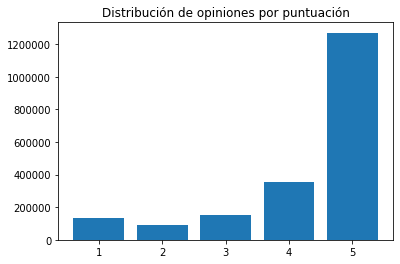

In [4]:
utils.perform_eda(data_raw_0, 'rating_distribution')

Comprobamos que si mostramos la misma información pero tomando la puntuación mediana por producto el efecto ese el mismo, incluso es algo más pronunciado:

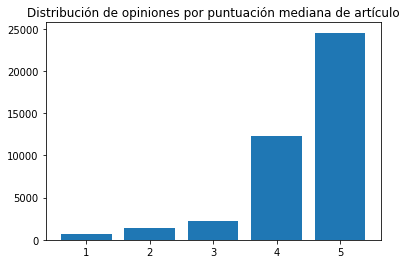

In [5]:
utils.perform_eda(data_raw_0, 'rating_distribution_item')

Veamos cuándo se registraron las opiniones de que disponemos:

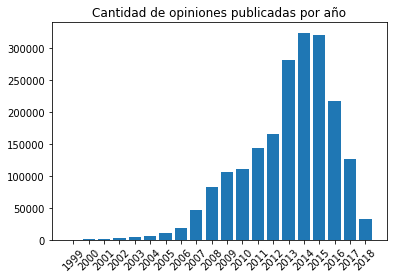

In [6]:
utils.perform_eda(data_raw_0, 'opinions_per_year')

El registro comienza en 1999 y termina en 2018, con un pico muy pronunciado entorno a los años 2014-2015.

Veamos ahora cuántas opiniones suelen tener los artículos.

Aparecen 41200 artículos distintos.


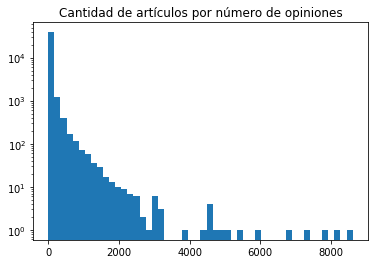

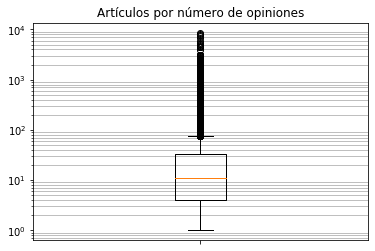

In [7]:
utils.perform_eda(data_raw_0, 'opinions_per_item')

Nótese la necesidad de una escala logarítmica. Si bien hay algunos artículos con una gran cantidad de opiniones, también podemos ver que la mediana está situada entorno a la quincena.

Igual que con los artículos, veamos ahora cuántas opiniones hay por usuario. ¿Cuántas opiniones publican los usuarios?

Aparecen 575237 usuarios distintos.


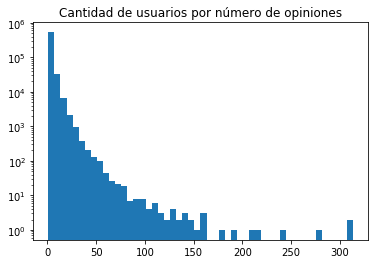

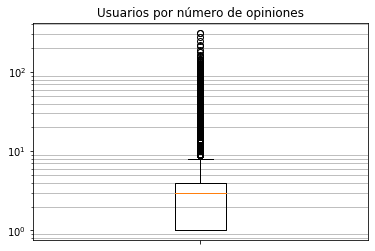

In [8]:
utils.perform_eda(data_raw_0, 'opinions_per_user')

Observamos un comportamiento similar al caso anterior: algunos usuarios han publicando cientos de opiniones, pero una enorme mayoría tan solo ha publicado unas pocas: la mediana es 7.

¿Cómo es la dispersión en las puntuaciones? Lo vemos en el siguiente boxplot:

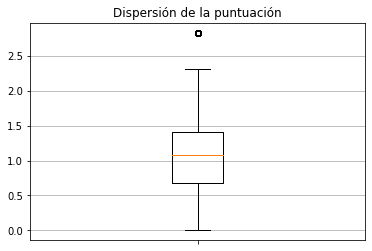

In [9]:
utils.perform_eda(data_raw_0, 'rating_sd_per_item')

La desviación estándar de las opiniones, calculada a nivel de artículo, tiene una mediana de 1.2, si bien puede llegar a ser bastante grande en algunos casos. Este resultado nos indica que la dispersión es, en general, no muy alta, y por tanto los artículos suelen contar con puntuaciones relativamente homogéneas.

Veamos cuál es la longitud media de las opiniones según la puntuación, así como la proporción entre el total del texto (summary + review) y summary.

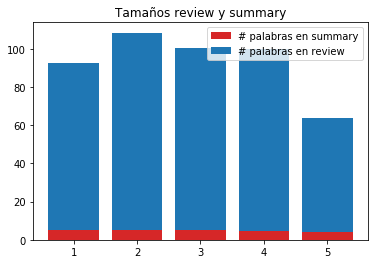

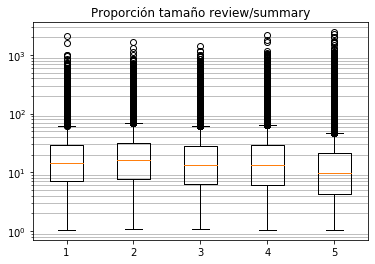

In [10]:
utils.perform_eda(data_raw_0, 'summary_review_length_comparison_per_rating')

Resulta llamativo el resultado para las opiniones de 5 estrellas. Mientras el resto de puntuaciones tienen textos claramente por encima de las 90 palabras, las opiniones de 5 estrellas tienen longitudes menores, por debajo de 70 palabras. Volveremos más adelante a revisar este resultado, pues este efecto podría deberse a que hay muchas más opiniones de 5 estrellas que del resto.

A continuación se muestra otro conjunto de boxplots con las longitudes totales de las opiniones. Vemos el efecto ya descrito en la celda anterior.

In [11]:
utils.perform_eda(data_raw_0, 'text_length_per_rating')

KeyboardInterrupt: 

A continuación eliminamos el sesgo y repetimos la fase EDA.

Para eliminar el sesgo tomamos todas las opiniones de 2 estrellas, pues es el grupo menos poblado, y realizamos un sampleo aleatorio sobre el resto del datset. Tras este sampleo, el contenido del fichero Electronics_5.json que finalmente empleamos es aproximadamente un cuarto del total.

Llamamos __data_raw_1__ al nuevo dataset.

In [ ]:
data_raw_1 = utils.remove_rating_bias_from_raw_data(data_raw_0)

In [ ]:
utils.perform_eda(data_raw_1, 'rating_distribution')

Confirmamos que todas las puntuaciones cuentan con la misma cantidad de opiniones: unas 300000

Veamos cómo cambia el aspecto de la distribución de puntuaciones por artículo, ahora que el dataset ya no tiene sesgo:

In [ ]:
utils.perform_eda(data_raw_1, 'rating_distribution_item')

Observamos una distribución aproximadamente normal, como es de esperar debido al Teorema del límite central. Nótese la diferencia respecto al mismo análisis sobre __data_raw_0__.

De nuevo, pintamos un histograma para ver cuántas opiniones se han publicado por año. Al haber realizado un sampleo aleatorio, esperamos que la forma sea la misma que antes.

In [ ]:
utils.perform_eda(data_raw_1, 'opinions_per_year')

A continuación, la distribución de artículos por número de opiniones.

In [ ]:
utils.perform_eda(data_raw_1, 'opinions_per_item')

Igual que antes, una gran mayoría de artículos tiene un número bajo de opiniones y tan solo algunos cuentan con cientos o incluso miles.

Como era de esperar, la representación de boxplot se ha desplazado hacia abajo. La mediana ha pasado de 15 a 4 debido a que hemos eliminado un gran número de opiniones.

Pintamos nuevamente un histograma y un boxplot para ver cuántas opiniones han publicado los usuarios.

In [ ]:
utils.perform_eda(data_raw_1, 'opinions_per_user')

Como es esperable, la forma del histograma es la misma (muchos usuarios con pocas opiniones y pocos usuarios con muchas opiniones) y el boxplot se ha desplazado hacia abajo, dando una mediana de 2, consistente con la reducción del volumen del datset.

A continuación vemos la dispersión de la puntuación por artículo.

In [ ]:
utils.perform_eda(data_raw_1, 'rating_sd_per_item')

Tras la eliminación del sesgo la dispersión se mantiene prácticamente igual que antes, si bien se ha desplazado ligeramente hacia valores más altos. Este efecto es coherente con el cambio en la distribución que hemos visto en el análisis 'rating_distribution_item', que ha pasado de una distribución muy sesgada hacia puntuaciones altas a una distribución más simétrica y centrada. En otras palabras, antes teníamos "muchos artículos buenos", valorados mayormente con 4 y 5 estrellas, y ahora no existe ese exceso de artículos buenos.

Comprobemos ahora si tras eliminar el sesgo las longitudes de los textos se han alterado.

In [ ]:
utils.perform_eda(data_raw_1, 'summary_review_length_comparison_per_rating')

Curiosamente las dos representaciones se mantienen prácticamente idénticas. Esto confirma que la anormal baja longitud de las opiniones de 5 estrellas no era debido a un efecto de sesgo. Mi interpretación es que los usuarios que están muy satisfechos con su compra tienden a publicar opiniones más escuetas, pues no necesitan mencionar tantos elementos como el resto de usuarios. De hecho, esta interpretación puede extenderse al resto de ratings. En las opiniones de 1 estrella los usuarios comentan acerca de diversos elementos pero están muy insatisfechos y no se molestan en hacer una revisión extensa. En las opiniones de 2 estrellas, el usuario admite elementos positivos pero ha de destacar otros tantos negativos. A medida que el usuario queda más y más satisfecho, la necesidad de extenderse va disminuyendo hasta observa el caso de las 5 estrellas.

Por último, volvamos a analiar las longitudes totales por puntuación.

In [ ]:
utils.perform_eda(data_raw_1, 'text_length_per_rating')

Resulta evidente el efecto ya comentado en la celda anterior. También comprobamos que solo se trata de una tendencia, no de una norma, pues las opiniones de 1 y 5 estrellas tienen algunas opiniones tan largas como el resto, como se puede interpretar de los outliers.

# Preparación de los datos

En esta sección tratamos el procesamiento de los datos. Los preparamos y le damos la estructura adecuada para realizar un análisis sobre ellos.

El objeto resultante del procesamiento lo llamaré __odf__ (Opinion Data Frame) y será una pieza clave pues todos los análisis se harán sobre el mismo. Este objeto, de tipo pandas.DataFrame, contendrá tantas filas como opiniones (aproximadamente 1.5 millones) y los campos son los siguientes:
* doc_number
* rating
* text
* summary_raw
* review_raw
* summary_tokens_length

La construcción del objeto odf se realiza bajo la función __execute_preprocessing_pipeline__, que es una rutina que ejecuta las distintas transformaciones que sufre el dataset suministrado, __data_raw_1__, hasta devolver el odf ya generado.

In [12]:
#odf = utils.execute_preprocessing_pipeline(data_raw_1, False)
odf = utils.load_latest_odf(nrows=892910, is_false=True) # 4 MILL
#odf = utils.load_latest_odf(nrows=17525, is_false=True) # 100 k
#odf = utils.load_latest_odf(nrows=214475, is_false=True) # 1 MILL

Mostrar un head del odf y explicar qué contiene cada campo.

# Análisis

El análisis que se lleva a cabo en este proyecto tiene por objetivo encontrar y mostrar de la mejor manera posible las relaciones que se establecen entre opiniones y temas. Por tanto, para realizar esta tarea vamos a necesitar dos partes previas a la extracción de insights:
* La detección, definición y construcción de temas
* La asignación de temas a opiniones

En las siguientes secciones se presentan las herramientas desarrolladas y los objetos definidos para llevar a cabo ambas partes.

Antes de ello, vamos a definir los elementos que van a ir apareciendo.
* __Tema:__ definimos un tema como un elemento de negocio. Cada tema tratará de representar una parte del proceso de compra de un producto en un comercio electrónico. Por la manera en que se definen, los temas están naturalmente compuestos por subtemas (aunque no siempre hay una barrera clara entre subtemas) y estos, a su vez, por combinaciones de keywords. Los veremos más adelante pero, por poner un ejemplo, uno de los temas trata de la experiencia en la entrega del paquete. Algunos temas se definen por parejas (un tema para la experiencia positiva y otro para la negativa) y otros temas no tienen esa dualidad.
* __Wordset:__ es el conjunto de palabras clave que constituyen un tema. No se trata simplemente de una lista sino que hay una cierta lógica, unas relaciones que deben cumplir los tokens con tal de considerarse un tema.
* __Token:__ en este trabajo un token puede ser una palabra o un bigrama. Ejemplos de token pueden ser "package" o "works_great".
* __Opinión:__ cuando usamos la palabra opinión nos referimos al objeto "Opinión", no al texto que escribe el usuario. La diferencia es que, en este análisis, la opinión es un objeto compuesto por varios campos: rating, review y summary.
* __Rating:__ es la puntuación de una opinión. Siempre tiene un valor entre 1 y 5.
* __Review:__ es el texto (largo) que escribe el usuario. Es, básicamente, lo que exploraremos para tratar de asignar temas a opiniones.
* __Summary:__ es el resumen o el título de la review. Como hemos visto en el EDA, la longitud del summary suele ser entorno a una décima parte la de la review. También exploramos en los summaries para asignar temas a opiniones.
* __Hit:__ asignación de un tema a una opinión.

## Herramientas y objetos

### Detección, definición y construcción de temas

Tras varios intentos fallidos de emplear métodos de Topic Modelling para la detección de los temas, decidí construir una metodología propia, basada en palabras clave. Definí un __tema__ como la estructura siguiente:

In [13]:
tema =  {
            'name': 'nombre del tema'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                            ,{
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                            ,...
                            ,{
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

El atributo name sencillamente identifica el tema.
El atributo wordset es el conjunto de palabras que identifican el tema. Su contenido se divide en dos piezas, los elementos "and" y los elementos "or". En el primer caso, todos los tokens que constituyen la lista de "ands" deben aparecer en el texto de la opinión (ya sea review o summary) con tal de que el algoritmo de búsqueda considere que se produce un hit. Los ors son el elemento más flexible. Es una lista de "grupos or". Cada grupo or contiene un concepto o bien una representación distinta de un mismo concepto, y el algoritmo de búsqueda considerará que se produce un hit si se satisface alguno de los grupos or.

La estructura de cada grupo or está compuesta de 4 listas. Una lista de sinónimos de tipo 0. Estos tokens suelen ser bigramas. Los sinónimos de tipo 1 requieren de un complemento, los sinónimos de tipo 2. Los nots son los tokens que, si se detectan próximas a un sinónimo de tipo 0 o 1 anulan el hit. Lo veremos con un ejemplo.

Vamos a ver el funcionamiento, tanto de los temas como del algoritmo de búsqueda, con unos ejemplos, pero primero veamos las opiniones sobre las que mostramos el funcionamiento:

In [14]:
#odf_prueba = odf.loc[[148, 1455, 2689, 2849, 7213, 13890, 59018, 774310, 83236, 3161181, 5183314]]
#for each in odf_prueba.iterrows():
#    print('Opinión #', str(int(each[1]['doc_number']))+':')
#    print('Rating:', str(int(each[1]['rating'])))
#    print(each[1]['review_raw'], '\n\n********************************************\n')

Veamos el funcionamiento del elemento "ands".

In [15]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  ['iphone']
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [16]:
#utils.analize_wordset(odf_prueba, tema, False)[0]['doc_number']

Comprobamos que se han localizado las 3 opiniones en las que aparece el token 'iphone':

Verificamos que si añadimos un token a la lista de "ands", la búsqueda es más restrictiva, pues solo harán hit las opiniones que contengan ambos tokens.

In [17]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  ['iphone', 'charger']
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [18]:
#utils.analize_wordset(odf_prueba, tema, False)[0]['doc_number']

Comprobamos que la opinión 13890 deja de aparecer, pues no contiene la palabra "charger".

A continuación buscaremos opiniones que contengan alguno de los dos tokens. Para ello empleamos la lista syn0 del grupo or.

In [19]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': ['iphone', 'charger'],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [20]:
#utils.analize_wordset(odf_prueba, tema, False)[0]['doc_number']

En esta ocasión aparecen todas las opiniones que contiene alguna de las dos (o las dos) palabras.

Ahora probemos una búsqueda algo más avanzada. Consideraremos 'phone' y 'iphone' como sinónimos, y exigiremos que aparezca el token 'charger'.

In [21]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  ['charger']
                , 'ors': [
                            {
                            'syn0': ['iphone', 'phone'],
                            'syn1': [],
                            'syn2': [],
                            'nots': []
                            }
                         ]
            }
        }

In [22]:
#utils.analize_wordset(odf_prueba, tema, False)[0]['doc_number']

Comprobamos que se trata del resultado esperado: la opinión 7213 contiene "charger" y "phone" y las otras dos contienen "charger" y "iphone".

En esta ocasión vamos a mostrar la diferencia entre los syn0 y los sin1/syn2. Definimos un tema que considere la inestabilidad del producto. Los syn0 serán 'unstable' y 'stability_issues', mientras que el syn1 será 'stable', apoyado por el complemento 'not'.

In [23]:
tema =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': ['unstable',
                                     'stability_issues'],
                            'syn1': ['stable'],
                            'syn2': ['not'],
                            'nots': []
                            }
                         ]
            }
        }

In [24]:
#utils.analize_wordset(odf_prueba, tema, False)[0]['doc_number']

Podemos comprobar fácilmente que ambas opiniones tratan el tema de la inestabilidad del producto.

Por último, veamos la importancia que puede tener el elemento 'not'. Para ello definimos dos temas iguales pero en uno de ellos le indicamos que los tokens 'not' y 'nor' no pueden aparecer próximos.

In [25]:
tema1 =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': ['plug'],
                            'syn2': ['play'],
                            'nots': []
                            }
                         ]
            }
        }
tema2 =  {
            'name': 'Prueba'
            , 'wordset':
            {
                'ands':  []
                , 'ors': [
                            {
                            'syn0': [],
                            'syn1': ['plug'],
                            'syn2': ['play'],
                            'nots': ['not']
                            }
                         ]
            }
        }

In [26]:
#utils.analize_wordset(odf_prueba, tema1, False)[0]['doc_number']

In [27]:
#utils.analize_wordset(odf_prueba, tema2, False)[0]['doc_number']

Hasta aquí hemos visto cómo funcionan los temas una vez están definidos pero cómo los definimos? Mediante un proceso manual asistido por diversas herramientas para explorar los tokens del corpus.

En primer lugar, es fundamental disponer del corpus del dataset, es decir, los tokens que aparecen en las opiniones, y también cuántas veces aparecen. Para ello hacemo uso del objeto Counter (Collections). Este objeto será necesario a nivel interno en varias ocasiones y también lo usamos a continuación para construir un diccionario. El diccionario lo construimos en este punto pero solamente lo necesitaremos para codificar el texto en la parte predictiva del trabajo.

In [28]:
# Construimos un contador para almacenar en cuántas ocasiones aparece cada token
token_counter = Counter()
for index, row in odf.iterrows():
    token_counter.update(row['text'].split(', '))


print("Cantidad de tokens (distintos) antes de eliminar los poco frecuentes:", str(len(token_counter.keys())).rjust(6, ' '))
for word in list(token_counter):
    if token_counter[word] < 2:
        del token_counter[word]
print("Cantidad de tokens (distintos) tras eliminar los poco frecuentes:    ", str(len(token_counter.keys())).rjust(6, ' '))


#Construimos el diccionario
tokens_coded = {'UNK':0}
for word in token_counter:
    tokens_coded[word] = len(tokens_coded) 

Cantidad de tokens (distintos) antes de eliminar los poco frecuentes: 249281
Cantidad de tokens (distintos) tras eliminar los poco frecuentes:     169497


In [29]:
token_counter.most_common(10)

[('not', 1215788),
 ('good', 322169),
 ('use', 274303),
 ('great', 265175),
 ('work', 228463),
 ('out', 183157),
 ('no', 180865),
 ('product', 178083),
 ('camera', 157968),
 ('time', 143694)]

Esa es la primera herramienta. Simplemente revisando manualmente los tokens más comunes es posible hacerse una idea de los temas que se tratan. Muchos de ellos no son útiles descontextualizados. Por ello, acudimos a los bigramas:

In [30]:
utils.extract_bigrams_from_counter(token_counter).head()

,bigram,num_occurrences
0,way_too,6693
1,cut_out,2684
2,east_coast,121
3,family_member,409
4,many_places,165


Los bigramas nos ofrecen una visión mucho más contextualizada. Si bien muchos de ellos no pueden ser interpretados por sí solos, sí hay otros que sí lo permiten.

La siguiente herramienta nos asiste en la interpretación de los tokens. Nos sirve para contextualizarlos y adquirir una noción de "qué se suele decir" allí donde se usan. La función __get_close_words__ nos devuelve los tokens más frecuentes que se encuentran unas posiciones antes (a la izquierda) del token buscado y las que se encuentran unas posicioens detrás (a la derecha). Asimismo, se recoge el número de ocasiones que aparecen e información sobre la puntuación: la media y la desviación estándar de aquellas opiniones en las que se ha encontrado el token seguido o precedido de cada palabra:

In [31]:
utils.get_close_words(odf, 'defective', max_distance=3, n_words=8)

00h 00m 00s ____ INICIO FUNCIÓN GET_CLOSE_WORDS ____________________________________________________
00h 00m 00s :::: BUCLE OPINIONES: 0 DE 892910 ______________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 200000 DE 892910 _________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 400000 DE 892910 _________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 600000 DE 892910 _________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 800000 DE 892910 _________________________________________________
00h 01m 24s ____ FIN FUNCIÓN GET_CLOSE_WORDS _______________________________________________________


(          num_occurrences  rating_mean  rating_sd
 token                                            
 unit                717.0     1.896792   0.981934
 product             548.0     1.616788   0.965138
 first               461.0     2.301518   1.236307
 maybe               441.0     1.861678   0.864137
 return              438.0     1.863014   1.032405
 mine                380.0     1.992105   0.879218
 returned            316.0     1.832278   1.036035
 know                274.0     1.755474   0.826788,
              num_occurrences  rating_mean  rating_sd
 token                                               
 product               1164.0     1.530928   0.837578
 returned               371.0     1.684636   0.879346
 box                    351.0     1.678063   0.917483
 replacement            338.0     1.937870   1.061458
 back                   337.0     1.732938   1.002919
 work                   336.0     1.660714   0.935728
 amazon                 334.0     1.823353   1.071859
 re

In [32]:
utils.get_close_words(odf, 'works_great', max_distance=3, n_words=8)

00h 00m 00s ____ INICIO FUNCIÓN GET_CLOSE_WORDS ____________________________________________________
00h 00m 00s :::: BUCLE OPINIONES: 0 DE 892910 ______________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 200000 DE 892910 _________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 400000 DE 892910 _________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 600000 DE 892910 _________________________________________________
00h 00m 15s :::: BUCLE OPINIONES: 800000 DE 892910 _________________________________________________
00h 01m 37s ____ FIN FUNCIÓN GET_CLOSE_WORDS _______________________________________________________


(            num_occurrences  rating_mean  rating_sd
 token                                              
 great                1920.0     4.311979   0.910859
 five_stars           1388.0     4.992795   0.136724
 product               856.0     3.998832   1.161265
 works                 779.0     3.994865   1.128037
 use                   704.0     4.107955   1.029988
 good                  585.0     4.114530   0.959208
 price                 529.0     4.389414   0.795085
 still                 529.0     3.778828   1.315066,
         num_occurrences  rating_mean  rating_sd
 token                                          
 use               796.0     4.128141   1.072779
 good              665.0     4.138346   1.027683
 easy              644.0     4.316770   0.927696
 price             606.0     4.389439   0.883356
 great             590.0     4.264407   1.028253
 love              311.0     4.385852   0.963357
 far               310.0     4.122581   1.066316
 little            305.0    

Simplemente con esta función ya nos damos cuenta de que algunas palabras están fuertemente relacionadas con la puntuación de las opiniones, como podemos ver en estas dos ejecuciones.

Otra asistencia relacionada con la definición de los wordsets es la que nos ofrece la función __busca_tokens__. Esta función nos permite ver en qué bigramas aparece un token dado.

In [33]:
utils.busca_tokens(token_counter, ['quality'])

['sound_quality',
 'quality_suffers',
 'quality_control',
 'quality__',
 'poorer_quality',
 'image_quality',
 'low_quality',
 'declining_quality',
 'quality_lightness',
 'tonal_quality',
 'quality_avcd',
 'poor_quality',
 'higher_quality',
 'bulid_quality',
 'quality_deteriorates',
 'picture_quality',
 'high_quality',
 'quality_materials',
 'questionable_quality',
 'pic_quality',
 'quality_assurance',
 'quality_varies',
 'lesser_quality',
 'highest_quality',
 'redeeming_quality',
 'build_quality',
 'exude_quality',
 'exudes_quality',
 'redeemable_quality',
 'quality',
 'poorest_quality']

Estas son las herramientas que, combinadas entre ellas y con una cierta dedicación, me han permitido definir los wordsets de los temas.

### Asignación de temas a opiniones (hits)

El mecanismo de asignación de temas a opiniones lo hemos visto en la sección anterior. Es un algoritmo que recibe como inputs el odf y el envoltorio del wordset que queremos analizar. Además, podemos indicarle si queremos visualizar el histograma de los resultados por puntuación.

El código de la función analize_wordset está diseñado para seguir la siguiente lógica (la describimos de forma aproximada, ya que el código contiene matices para mejorar el rendimiento y la precisión):

* para cada opinión en el odf:
  * si se cumple la condición de los ands en el texto:
    * ands_compliance = True
    * si se cumple algún grupo or en el texto:
      * ors_compliance = True
  * si ands_compliance y ors_compliance:
    * se produce un hit

Algunos mecanismos que incluye el código para mejorar el rendimiento:
* Primero se realiza la búsqueda sobre el summary. De no satisfacerse las condiciones, entonces se busca en la review.
* No se procesa todo el texto sino que en primer lugar se localizan las posiciones de los tokens del wordset y entonces seleccionamos una porción del texto que los envuelve. De este modo reducimos drásticamente la longitud del texto a procesar. La porción de texto a estudiar se establece mediante un parámetro, max_distance, que se ha establecido en 3. Esto hace que el texto a estudiar sea, en muchas ocasiones, de tan solo 7 tokens.

Algunos mecanismos para mejorar la precisión:
* En la línea de establecer una distancia máxima de 3 tokens, esta es la distancia máxima a la que pueden estar los elementos syn1 y syn2 para ser contabilizados.
* De los elementos not, por su naturaleza, solo se comprueba su existencia en las max_distance posiciones previas al token de interés, no en las posteriores.

A continuación generamos el listado de tokens que aparecen en el odf. Este paso es necesario porque algunos temas utilizan la función busca_tokens en su wordset, a la cual es necesario suministrar el listado.

## Definición de temas y obtención de los hits

A continuación se procede a recuperar los temas que han sido definidos empleando las herramientas ya comentadas.

In [34]:
topics = th.generate_topics(token_counter)
topics_names = utils.get_all_topic_names(topics)

Vamos a ver qué temas se han definido:

In [35]:
topics_names

['Funcionamiento (POS)',
 'Funcionamiento (NEG)',
 'Características (POS)',
 'Características (NEG)',
 'Comodidad/Sencillez (POS)',
 'Comodidad/Sencillez (NEG)',
 'Producto incorrecto',
 'Referencia a opiniones',
 'Envío/entrega/packaging (POS)',
 'Envío/entrega/packaging (NEG)',
 'Devolución/Postventa (POS)',
 'Devolución/Postventa (NEG)',
 'Precio',
 'Sentimiento (POS)',
 'Sentimiento (NEG)']

Nótese que algunos temas son duales (tienen su versión positiva y negativa) y otros son sencillos.

A continuación vamos a lanzar el bucle responsable de generar todos los hits. Para cada tema se ejecuta la función analize, ya explicada anteriormente, y se almacenan los resultados en el objeto lista_resultados_analize.

In [36]:
lista_resultados_analize = []
t = utils.calcula_y_muestra_tiempos('INICIO BUCLE ANALIZE', timestamps=[])
for topic_name in topics_names:
    res_fil, res_agg = utils.analize_wordset(odf, th.get_topic_by_name(topics, topic_name), False)
    print()
    lista_resultados_analize.append({'name':topic_name, 'resultados': res_fil, 'agregados': res_agg})
utils.calcula_y_muestra_tiempos('FIN BUCLE ANALIZE', timestamps=t)

00h 00m 00s ____ INICIO BUCLE ANALIZE ______________________________________________________________
00h 00m 00s ____ INICIO FUNCIÓN ANALIZE_WORDSET ____________________________________________________
00h 00m 00s :::: WORDSET A ANALIZAR: Funcionamiento (POS) __________________________________________
00h 00m 00s :::: BUCLE OPINIONES: 0 DE 892910 HITS: 0 ______________________________________________
00h 00m 18s :::: BUCLE OPINIONES: 200000 DE 892910 HITS: 18401 _____________________________________
00h 00m 18s :::: BUCLE OPINIONES: 400000 DE 892910 HITS: 37300 _____________________________________
00h 00m 18s :::: BUCLE OPINIONES: 600000 DE 892910 HITS: 56804 _____________________________________
00h 00m 18s :::: BUCLE OPINIONES: 800000 DE 892910 HITS: 75345 _____________________________________
00h 01m 23s ____ FIN FUNCIÓN ANALIZE_WORDSET _______________________________________________________
00h 00m 00s ____ INICIO FUNCIÓN ANALIZE_WORDSET ___________________________________________

00h 00m 16s :::: BUCLE OPINIONES: 200000 DE 892910 HITS: 799 _______________________________________
00h 00m 16s :::: BUCLE OPINIONES: 400000 DE 892910 HITS: 1736 ______________________________________
00h 00m 16s :::: BUCLE OPINIONES: 600000 DE 892910 HITS: 2651 ______________________________________
00h 00m 16s :::: BUCLE OPINIONES: 800000 DE 892910 HITS: 3576 ______________________________________
00h 01m 13s ____ FIN FUNCIÓN ANALIZE_WORDSET _______________________________________________________
00h 00m 00s ____ INICIO FUNCIÓN ANALIZE_WORDSET ____________________________________________________
00h 00m 00s :::: WORDSET A ANALIZAR: Devolución/Postventa (NEG) ____________________________________
00h 00m 00s :::: BUCLE OPINIONES: 0 DE 892910 HITS: 0 ______________________________________________
00h 00m 16s :::: BUCLE OPINIONES: 200000 DE 892910 HITS: 141 _______________________________________
00h 00m 16s :::: BUCLE OPINIONES: 400000 DE 892910 HITS: 293 ______________________________

00h 00m 00s ____ INICIO FUNCIÓN ANALIZE_WORDSET_OCCURRENCES ________________________________________
00h 00m 00s :::: SE PROCEDE A ANALIZAR EL WORDSET Funcionamiento (POS) _____________________________
00h 00m 00s :::: BUCLE: 0 de 83675 _________________________________________________________________
00h 00m 10s :::: BUCLE: 20000 de 83675 _____________________________________________________________
00h 00m 10s :::: BUCLE: 40000 de 83675 _____________________________________________________________
00h 00m 10s :::: BUCLE: 60000 de 83675 _____________________________________________________________
00h 00m 10s :::: BUCLE: 80000 de 83675 _____________________________________________________________
00h 00m 01s :::: SE PROCEDE A ANALIZAR EL WORDSET Funcionamiento (NEG) _____________________________
00h 00m 00s :::: BUCLE: 0 de 45166 _________________________________________________________________
00h 00m 10s :::: BUCLE: 20000 de 45166 ____________________________________________________

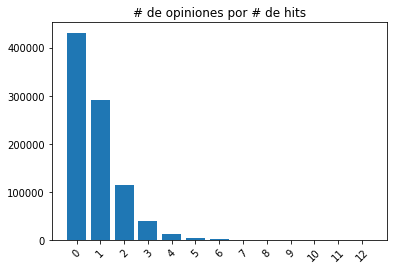

La ocupación parcial es del 52%
La ocupación total es del 11%
00h 06m 28s ____ FIN FUNCIÓN ANALIZE_WORDSET_OCCURRENCES ___________________________________________


In [37]:
mat_doc_ws, mat_doc_ws_agg = utils.analize_wordset_occurrences(odf, lista_resultados_analize)

Vemos el porcentaje de opiniones sobre las que hemos conseguido al menos un hit. Se muestra un histograma donde se lee cuántas opiniones tratan qué cantidad de temas.

Hay que destacar que los resultados que se han obtenido, y que se seguirán obteniendo en esta sección, se han cosechado con una metodología en base a palabras clave. Esto quiere decir que los resultados solo muestran aquellos hits que pueden producirse con esta estrategia y hay que tener esto en cuenta durante la interpretación.

Una consecuencia posible del uso de esta técnica es, por ejemplo, que algunos temas estén muy poblados debido a que hay una expresión muy recurrente y muy propia de cierto tema. En el contexto del análisis de texto siempre hay múltiples maneras de expresar un mismo concepto, pero no todas las maneras son detectables mediante el uso de keywords. Considero, de todos modos, que los resultados obtenidos son acorde con lo que se espera y, por tanto, interpreto que el algoritmo analize es  efectivo en su propósito. El porcentaje de opiniones que quedan por asociar a un tema, así como las opinones en las que se han detectado menos temas de los que realmente deberían haberse detectado, es achacable a formas de expresar conceptos que no son detectables mediante keywords.

Antes de explorar las relaciones entre los distintos temas, veamos la distribución de puntuaciones que tiene cada uno de los temas:

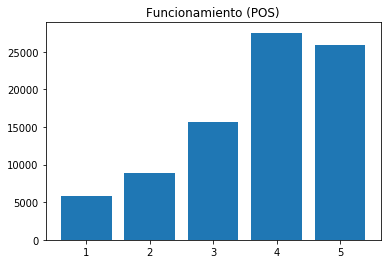

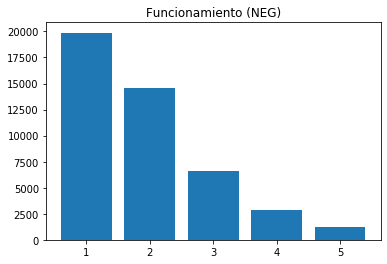

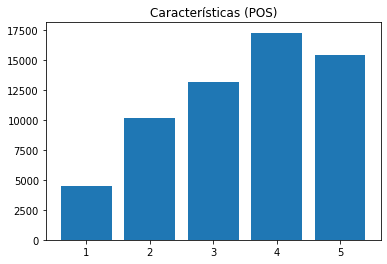

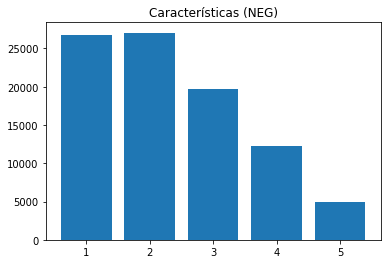

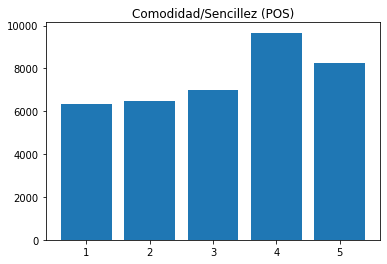

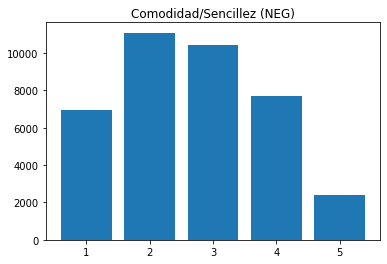

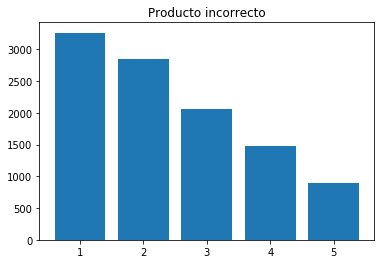

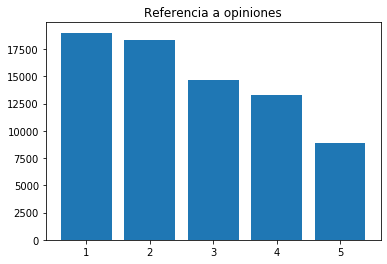

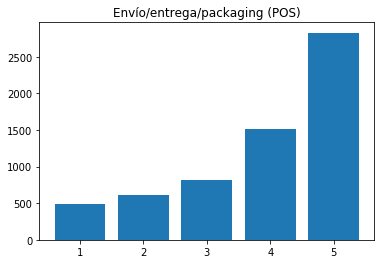

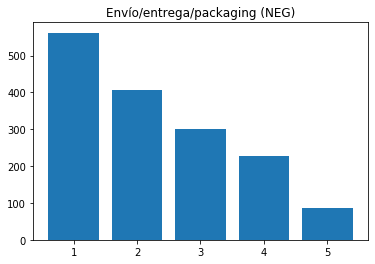

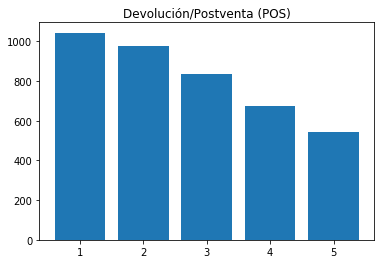

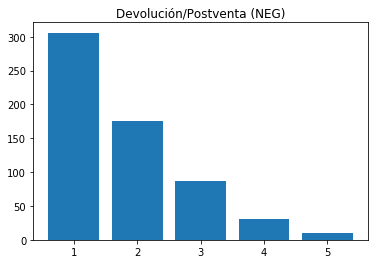

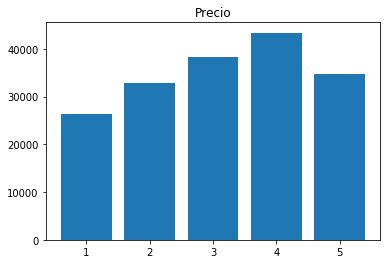

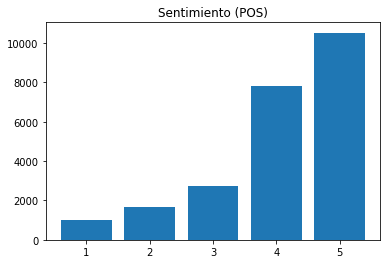

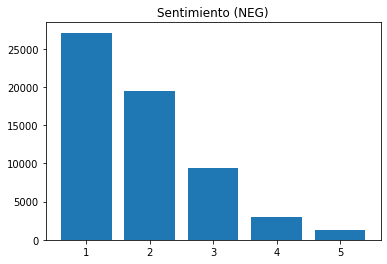

In [38]:
for item in lista_resultados_analize:
    utils.print_simple_histogram(item['agregados']['doc_number'], title=item['name'])

En los anteriores histogramas vemos con mucha claridad las tendencias de cada tema. Por ejemplo, para el primer tema, Funcionamiento (POS), se observa una clara tendencia hacia opiniones de puntuaciones altas. Por contra, en el tema Funcionamiento (NEG) se ve que la mayoría de opiniones que comentan aspectos negativos del funcionamiento son de puntuaciones bajas. Se pueden explorar todos los gráficos y ver cómo en algunos casos las tendencias son muy claras y en otros no lo son tanto, dando lugar a interpretar que no todos los temas son igual de críticos.

La primera pregunta que vamos a tratar de responder es: ¿de qué manera se relacionan las opiniones, los temas y las puntuaciones?

Para ello, vamos a realizar una representación de tipo red, donde cada nodo es o bien una opinión o bien un tema y cada arista une una opinión con un tema, pudiendo haber varias aristas uniendo una opinión con varios nodos. El color de las aristas representará la puntuación.

El tiempo de respuesta de representar todas las opiniones individualmente es inaceptable, además de que se trata de una cantidad muy elevada y el resultado es un gráfico en el que no se aprecia apenas nada. Para solucionar este inconveniente, la representación se modifica de manera que se agrupan todas las opiniones equivalentes y todas ellas generan un solo nodo (el nodo en sí se muestra con un tamaño cero, pues lo interesante son las aristas). Las opiniones equivalentes son todas aquellas que son de la misma puntuación y tienen los mismos hits. El tamaño (grosor) de las aristas es proporcional al número de opiniones equivalentes que contienen los nodos.

Veamos el aspecto:

In [39]:
#utils.visualize_wordsets_network_6(mat_doc_ws, group_size=1000, k=0.3, ratings='F')

También puede verse por puntuación. Veamos las 5:

In [40]:
#utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[5])

In [41]:
#utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[4])

In [42]:
#utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[3])

In [43]:
#utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[2])

In [44]:
#utils.visualize_wordsets_network_6(mat_doc_ws, group_size=500, k=0.3, ratings=[1])

Ya hemos observado qué aspecto tienen las relaciones. Se observan algunos temas muy unidos, especialmente para algunos rangos de puntuación, y otros menos.

La segunda pregunta que nos planteamos es ¿cómo de enlazados están los temas?. Ya se ha visto en las representaciones de red, pero veámoslo de forma cuantitativa y clara.

A continuación vemos la "matriz de compartición". Su objetivo es mostrar cuántas opiniones tienen en común un par de temas dado. La escala, con valores menores que la unidad, indica el porcentaje de opiniones que comparte. Naturalmente, el porcentaje de una pareja de temas no es simétrico, pues cada tema genera un volument total de hits distinto. Por ese motivo se muestra el valor medio de cada pareja.

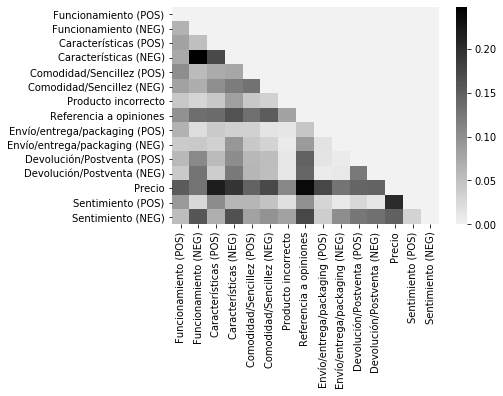

In [45]:
sm = utils.get_sharing_matrix_2(mat_doc_ws)

Para evitar que la diagonal eleve a 1 el máximo de la escala de color, he eliminado la diagonal, así se perciben mejor las diferencias de color entre las celdas. Incluso con estas modificaciones sigue siendo evidente el hecho de que algunos temas son más sencillos de identificar que otros, como por ejemplo el tema del precio

En la celda siguiente representamos la cantidad de opiniones por tema y rating. Debe leerse en horizontal, pues la matriz se ha normalizado para cada tema.

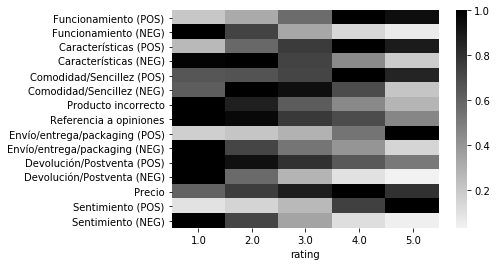

In [46]:
utils.print_topic_heatmaps(mat_doc_ws)

En realidad, este heatmap es equivalente a representar, en un mismo espacio, cada uno de los histogramas que ya hemos visto más arriba, pintados por la función analize.

El siguiente heatmap se lee en vertical. Muestra, por cada puntuación, cuántos hits ha generado cada tema (normalizado por puntuación).

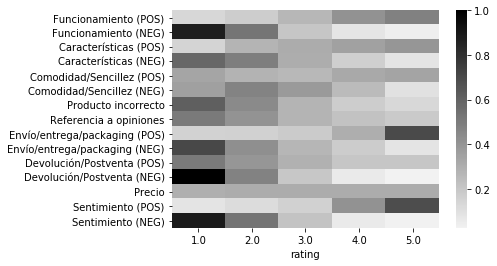

In [47]:
utils.print_rating_heatmaps(mat_doc_ws)

A continuación mostramos las 10 combinaciones más frecuentes.

In [48]:
utils.get_popular_topic_combinations(mat_doc_ws_agg, utils.get_wordsets_names(mat_doc_ws))

,Núm. de hits,1,2,10,11,12
1446,9181.0,Funcionamiento (POS),Precio,None,None,None
49,8858.0,Referencia a opiniones,Precio,None,None,None
346,8842.0,Características (NEG),Precio,None,None,None
561,8101.0,Características (POS),Precio,None,None,None
1069,5412.0,Funcionamiento (NEG),Características (NEG),None,None,None
1,4736.0,Precio,Sentimiento (NEG),None,None,None
740,4299.0,Características (POS),Características (NEG),None,None,None
2,3644.0,Precio,Sentimiento (POS),None,None,None
46,3479.0,Referencia a opiniones,Sentimiento (NEG),None,None,None
343,3419.0,Características (NEG),Sentimiento (NEG),None,None,None


En la tabla anterior se recoge el top 10 de combinaciones frecuentes. Este es un punto en el que puede verse muy claro el efecto de emplear palabras clave para generar hits.

A continuación comparamos las puntuaciones de aquellas opiniones que sí tratan un tema vs aquellas opiniones que no lo tratan. El color representa la puntuación media de las opiniones. La columna de No Hit, es decir las opiniones que no tratan del tema, la vemos muy pálida. Esto es porque, para cada tema, la mayoría de opiniones no tratan de él, por lo que la columna No Hit tiene un color muy próximo a la puntuación media.

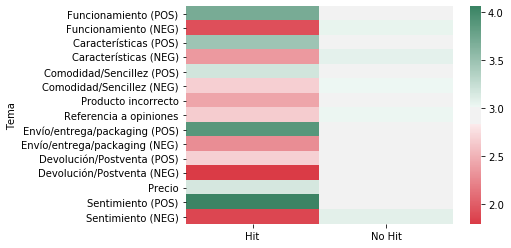

In [49]:
utils.print_statistics_by_topic_heatmap_rating_value(mat_doc_ws)

El siguiente heatmap es complementario al anterior. Se visualiza la dispersión en las puntuaciones de cada tema.

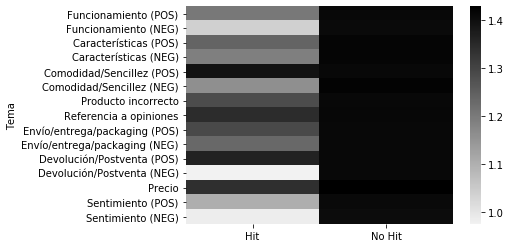

In [50]:
utils.print_statistics_by_topic_heatmap_rating_sd(mat_doc_ws)

Por último veamos cómo responde el comprador a cada tema. El objetivo es ver cómo penaliza/beneficia cada tema.

In [51]:
utils.get_respuesta_comprador(lista_resultados_analize, mat_doc_ws)

,Tema,Coef. Respuesta
13,Sentimiento (POS),0.106
8,Envío/entrega/packaging (POS),0.089
0,Funcionamiento (POS),0.070
2,Características (POS),0.048
4,Comodidad/Sencillez (POS),0.019
12,Precio,0.016
5,Comodidad/Sencillez (NEG),-0.032
10,Devolución/Postventa (POS),-0.032
7,Referencia a opiniones,-0.034
6,Producto incorrecto,-0.058


El objetivo de esta tabla es doble. Por un lado, ver a qué temas responde mejor el comprador, en términos de rating, y cuáles penalizan más. Por otro lado, en aquellos temas dobles (los que tienen su versión positiva y su versión negativa) ver si está mejor recompensada la versión positiva o si penaliza más la versión negativa.

Si descartamos los sentimientos, que no son temas per se, vemos que el tema mejor recompensado es el que refiere a Envío/entrega/packagin, incluso por encima del buen funcionamiento.

Por la parte negativa, observamos que un mal servicio postventa es el tema que más penaliza, incluso más que un mal funciomaniento, probablemente debido a que un un consumidor que se ve obligado a hacer uso del servicio postventa no admite que este le suponga una mala experiencia.

### Conclusiones del análisis

El análisis realizado ha extraído información de los datos originales, desestructurados, permitiendo su interpretación. A lo largo de las secciones anteriore se han ido extrayendo conclusiones. A continuación vamos a resumirlas.

* Los usuarios tienden a emitir puntuaciones altas, sobre todo de 5 estrellas.
* En general, los productos tienen unas pocas opiniones (del orden de una decena), aunque hay algunos pocos productos que cuentan con miles de opiniones.
* Los usuarios suelen publicar pocas opiniones, si bien hay algunos que cuentan con cientos de ellas.
* La longitud de las opiniones está relacionada con la puntuación de las mismas. Las opiniones 5 estrellas son notablemente más cortas que el resto. La interpretación es la siguiente: los usuarios que están muy satisfechos con su compra no necesitan dar muchos detalles ni comentar sobre muchos elementos. Del mismo modo, los usuarios que están muy insatisfechos (opiniones de 1 estrella) tampoco invierten tiempo en ello. Las puntuaciones intermedias se corresponden con opiniones más largas.

# Predicción de puntuaciones

En esta parte del trabajo se va a realizar la predicción de la puntuación de las opiniones y comparar varias estrategias.

En primer lugar vamos a predecir las puntuaciones en base al texto, empleando un clasificador de tipo CART (RandomForestClassifier) y apoyándonos en el objeto CountVectorizer para el encoding.

## Sobre el texto, usando RandomForest

In [52]:
#clf_model_texto = RandomForestClassifier(n_estimators=10)
clf_model_texto = DecisionTreeClassifier()
cv = CountVectorizer()
X_texto = cv.fit_transform(odf['text'])
y_texto = utils.map_rating(odf['rating'])

Procedemos a generar dos conjuntos, uno de entrenamiento y otro para la validación (test).

In [53]:
X_train_texto, X_test_texto, y_train_texto, y_test_texto = train_test_split(X_texto, y_texto, random_state=2020)

A continuación se realiza el entrenamiento del modelo.

In [54]:
t = utils.calcula_y_muestra_tiempos('INICIO ENTRENAMIENTO', timestamps=[])
clf_model_texto.fit(X_train_texto, y_train_texto)
utils.calcula_y_muestra_tiempos('FIN ENTRENAMIENTO', timestamps=t)

00h 00m 00s ____ INICIO ENTRENAMIENTO ______________________________________________________________
01h 19m 01s ____ FIN ENTRENAMIENTO _________________________________________________________________


Y a continuación evaluamos los resultado sobre el conjunto de validación.

En este escenario, la precisión (accuracy) no parece la métrica más significativa, pues, por la naturaleza del campo objetivo, predecir un 5 cuando la respuesta correcta es 4 no es igual de malo que predecir un 1. Por ello, si bien también calcularemos la precisión, la métrica de referencia será el **error cuadrático medio (RMSE)**.

La función evaluar_modelo_reg retorna un gráfico donde podemos ver la distribución de los errores en la predicción. Así, la barra correspondiente al valor 0 muestra las predicciones correctas; la correspondiente al valor 1 muestra las predicciones que son incorrectas por 1 estrella, y así sucesivamente.

Además, se imprime el ratio acumulado. Así, vemos que casi un 90% de las predicciones son correctas o bien están erradas por 1 estrella. A esta métrica la llamamos Acc1- (predicciones correctas o erradas por 1 estrella), y es, junto con el error cuadrático medio, la métrica de referencia en este trabajo.

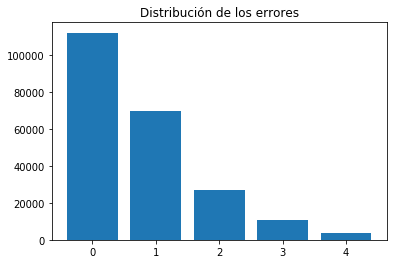

Acumulados           Parciales           
0: 0.50 (112217)     0: 0.50 (112217)    
1: 0.81 (181871)     1: 0.31 (69654)     
2: 0.94 (208828)     2: 0.12 (26957)     
3: 0.98 (219557)     3: 0.05 (10729)     
4: 1.00 (223228)     4: 0.02 (3671)      

Accuracy: 0.50
Acc1-: 0.81
RMSE: 1.22


In [55]:
utils.evaluar_modelo_reg(clf_model_texto, X_test_texto, y_test_texto)

## Sobre los temas, usando RandomForest

En este caso vamos a tratar de realizar la predicción basándonos exclusivamente en los temas tratados. Hay que tener en cuenta que, naturalmente, solo podremos realizar esta predicción sobre aquellas opiniones en las que hemos generado algún hit.

Previsiblemente, la precisión será menor.

00h 00m 00s ____ INICIO ENTRENAMIENTO ______________________________________________________________
00h 00m 17s ____ FIN ENTRENAMIENTO _________________________________________________________________


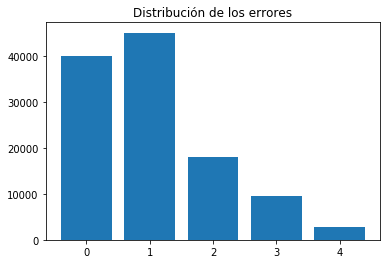

Acumulados           Parciales           
0: 0.35 (39964)      0: 0.35 (39964)     
1: 0.74 (85048)      1: 0.39 (45084)     
2: 0.89 (103046)     2: 0.16 (17998)     
3: 0.98 (112616)     3: 0.08 (9570)      
4: 1.00 (115453)     4: 0.02 (2837)      

Accuracy: 0.35
Acc1-: 0.74
RMSE: 1.47


In [56]:
clf_model_temas = RandomForestClassifier()

mat_doc_ws_2 = mat_doc_ws[mat_doc_ws['total_wordsets'] > 0]
docs_con_tema = list(mat_doc_ws_2.index.values)

X_temas = mat_doc_ws_2[topics_names]
y_temas = utils.map_rating(mat_doc_ws_2['rating'])

X_train_temas, X_test_temas, y_train_temas, y_test_temas = train_test_split(X_temas, y_temas, random_state=2020)
t = utils.calcula_y_muestra_tiempos('INICIO ENTRENAMIENTO', timestamps=[])
clf_model_temas.fit(X_train_temas, y_train_temas)
utils.calcula_y_muestra_tiempos('FIN ENTRENAMIENTO', timestamps=t)

utils.evaluar_modelo_reg(clf_model_temas, X_test_temas, y_test_temas)

## Sobre el texto, usando LSTM

In [57]:
odf_lstm = odf[['text', 'rating_0']]
odf_lstm['encoded'] = odf_lstm['text'].apply(lambda x: np.array(utils.encode_sentence_(x, tokens_coded)))

X = list(odf_lstm['encoded'])
y = list(odf_lstm['rating_0'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
train_ds = utils.ReviewsDataset(X_train, y_train)
valid_ds = utils.ReviewsDataset(X_valid, y_valid)

batch_size = 2000
vocab_size = len(tokens_coded)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(valid_ds, batch_size=batch_size)

In [58]:
model = utils.LSTM_fixed_len(vocab_size=vocab_size, embedding_dim=50, hidden_dim=50)

In [59]:
t = utils.calcula_y_muestra_tiempos('INICIO ENTRENAMIENTO', timestamps=[])
utils.train_model(model, train_dl, val_dl, epochs=20, lr=0.01)
utils.calcula_y_muestra_tiempos('FIN ENTRENAMIENTO', timestamps=t)

00h 00m 00s ____ INICIO ENTRENAMIENTO ______________________________________________________________
train loss 1.522, val loss 1.162, val accuracy 0.492, and val rmse 1.013
train loss 0.992, val loss 0.900, val accuracy 0.606, and val rmse 0.838
train loss 0.860, val loss 0.877, val accuracy 0.617, and val rmse 0.825
train loss 0.808, val loss 0.868, val accuracy 0.623, and val rmse 0.825
train loss 0.766, val loss 0.888, val accuracy 0.622, and val rmse 0.838
train loss 0.726, val loss 0.902, val accuracy 0.619, and val rmse 0.818
train loss 0.689, val loss 0.922, val accuracy 0.616, and val rmse 0.834
train loss 0.654, val loss 0.960, val accuracy 0.612, and val rmse 0.852
train loss 0.625, val loss 0.982, val accuracy 0.611, and val rmse 0.866
train loss 0.599, val loss 1.033, val accuracy 0.608, and val rmse 0.860
train loss 0.576, val loss 1.056, val accuracy 0.608, and val rmse 0.872
train loss 0.556, val loss 1.085, val accuracy 0.605, and val rmse 0.876
train loss 0.538, val l

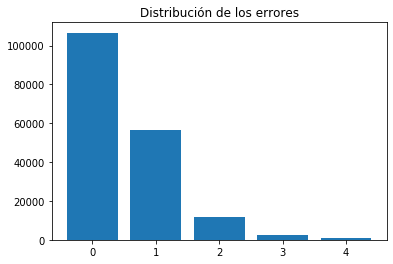

Acumulados           Parciales           
0: 0.60 (106664)     0: 0.60 (106664)    
1: 0.92 (163403)     1: 0.32 (56739)     
2: 0.98 (175116)     2: 0.07 (11713)     
3: 1.00 (177729)     3: 0.01 (2613)      
4: 1.00 (178582)     4: 0.00 (853)       

Accuracy: 0.60
Acc1-: 0.92
RMSE: 0.89


In [60]:
utils.evaluar_modelo_lstm(model, val_dl)